# Analyzing Bicycle Trip Data of Pittsburgh's Healthy Ride Program
This notebook analyzes bikeshare trip data for Pittsburgh's local bikeshare program, Healthy Ride. This analysis is motivated by a hypothetical business intelligence goal for the Healthy Ride organization to learn more about bicycle and station utilization in order to focus maintenance efforts on the most heavily used assets. This notebook seeks to answer questions related to station and bike utilization descriptive statistics, infers relationships between trip duration and user type and day of week variables, and attempts to model trip duration based on these variables.
    
    
### Table of Contents

* [Gather and Assess](#chapter1)
* [Clean](#chapter2)
* [Analyze and Model](#chapter3)
* [Summary of Insights](#chapter4)


## 1. Gather and Assess <a class="anchor" id="chapter1"></a>
Bicyle trip data for Pittsburgh's Healthy Ride program was collected by the Western Pennsylvania's Regional Data Center, and can be accessed [here](https://data.wprdc.org/dataset/healthyride-trip-data). The specific dataset used for this analysis is the "Healthy Ride Rentals - 2020 Q3" dataset.


#### Load modules and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#### Assess

In [2]:
df = pd.read_csv('data/healthy-ride-rentals-q3-2020.csv')
print(df.head())
print(df.columns)
print(df.info())

    Trip id       Starttime        Stoptime  Bikeid  Tripduration  \
0  98883652  7/1/2020 22:01  7/1/2020 22:22   70207          1283   
1  98978499  7/2/2020 19:37  7/3/2020 13:36   70207         64751   
2  99138944  7/4/2020 12:05  7/4/2020 13:29   70097          5046   
3  99159710  7/4/2020 14:41  7/4/2020 14:46   70097           326   
4  99165564  7/4/2020 15:35  7/4/2020 15:53   70487          1084   

   From station id            From station name  To station id  \
0           1048.0        S 18th St & Sidney St         1048.0   
1           1048.0        S 18th St & Sidney St         1072.0   
2           1074.0  South Side Trail & S 4th St         1074.0   
3           1074.0  South Side Trail & S 4th St         1072.0   
4          49611.0        24th St & Smallman St        49611.0   

               To station name    Usertype  
0        S 18th St & Sidney St    Customer  
1                   Glasshouse    Customer  
2  South Side Trail & S 4th St    Customer  
3       

- **Convert times to datetime format**

In [3]:
np.sum(df.isnull())

Trip id                 0
Starttime               0
Stoptime                0
Bikeid                  0
Tripduration            0
From station id      2714
From station name       0
To station id        3064
To station name         1
Usertype                8
dtype: int64

In [4]:
df['From station name'].value_counts()

Liberty Ave & Stanwix St                    2836
North Shore Trail & Fort Duquesne Bridge    2715
S 27th St & Sidney St. (Southside Works)    1451
Hot Metal St & Tunnel Blvd                  1423
Forbes Ave & Market Square                  1106
                                            ... 
BIKE 70077                                     1
BIKE 70403                                     1
BIKE 70562                                     1
BIKE 70626                                     1
BIKE 70429                                     1
Name: From station name, Length: 574, dtype: int64

In [5]:
df['To station name'].value_counts()

Liberty Ave & Stanwix St                    3057
North Shore Trail & Fort Duquesne Bridge    2798
S 27th St & Sidney St. (Southside Works)    1534
Hot Metal St & Tunnel Blvd                  1514
Isabella St & Federal St (PNC Park)         1137
                                            ... 
recording_101404209                            1
Pittsburgh - 5522 Baum Boulevard               1
BIKE 70154                                     1
919 Fulton St                                  1
recording_100542339                            1
Name: To station name, Length: 603, dtype: int64

- **Some stations are not locations. It could be that these non-locations lack a station id**

In [6]:
df.describe()

,Trip id,Bikeid,Tripduration,From station id,To station id
count,4.361600e+04,43616.000000,43616.000000,40902.000000,40552.000000
mean,1.031148e+08,70405.281686,5746.463225,8831.596450,8312.687734
std,2.378747e+06,209.728651,14987.859026,17945.458291,17372.548985
min,9.878238e+07,70004.000000,60.000000,1000.000000,1000.000000
25%,1.011272e+08,70217.000000,751.000000,1013.000000,1013.000000
50%,1.031877e+08,70446.000000,1851.000000,1041.000000,1040.000000
75%,1.050575e+08,70586.000000,4222.000000,1084.000000,1084.000000
max,1.072691e+08,71165.000000,172507.000000,88888.000000,88888.000000


- **Confirm Tripduration units - and confirm that trip durations are accurate**

In [7]:
df.Usertype.value_counts()

Customer      29416
Subscriber    14192
Name: Usertype, dtype: int64

- **Need to create new features to classify trip types and day of the week**

## 2. Clean <a class="anchor" id="chapter2"></a>

Summary of cleaning steps:
 - A. Convert times to datetime format
 - B. Some stations are not locations. It could be that these non-locations lack a station id
 - C. Confirm Tripduration units - and confirm that trip durations are accurate
 - D. Need to create new features to classify trip types and day of the week

#### A. Convert times to datetime format

In [8]:
df['Starttime'] = pd.to_datetime(df['Starttime'])
df['Stoptime'] = pd.to_datetime(df['Stoptime'])

#### B. Some stations are not locations. It could be that these non-locations lack a station id

In [9]:
df[df['From station id'].isnull()]['From station name'].value_counts()

Missing                       117
BIKE 70141                     31
BIKE 70678                     30
BIKE 70612                     24
BIKE 70540                     23
                             ... 
recording_100162480             1
BIKE 70274                      1
Stanton Ave & N Negley Ave      1
recording_100542339             1
BIKE 70684                      1
Name: From station name, Length: 433, dtype: int64

Having personally used a Healthy Ride rental, I just happen to know that it's possible to end a rental of a bicyle in any location - it does not have to be an actual station. So, I am assuming that trips with these non-standard locations are indeed valid trips. But, I will add a column that identifies these trips as either "Station to Station" or "Other" to exclude the "Other" trips from any analysis where it is not relevant.

In [10]:
# Classify strips as being either from station to station or other
trip_type = []

for i in range(len(df)):
    if (math.isnan(df['From station id'][i]) == True) or (math.isnan(df['To station id'][i]) == True):
        trip_type.append('Other')
    else:
        trip_type.append('Station to Station')

df['trip_type'] = trip_type

df.head()

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,trip_type
0,98883652,2020-07-01 22:01:00,2020-07-01 22:22:00,70207,1283,1048.0,S 18th St & Sidney St,1048.0,S 18th St & Sidney St,Customer,Station to Station
1,98978499,2020-07-02 19:37:00,2020-07-03 13:36:00,70207,64751,1048.0,S 18th St & Sidney St,1072.0,Glasshouse,Customer,Station to Station
2,99138944,2020-07-04 12:05:00,2020-07-04 13:29:00,70097,5046,1074.0,South Side Trail & S 4th St,1074.0,South Side Trail & S 4th St,Customer,Station to Station
3,99159710,2020-07-04 14:41:00,2020-07-04 14:46:00,70097,326,1074.0,South Side Trail & S 4th St,1072.0,Glasshouse,Subscriber,Station to Station
4,99165564,2020-07-04 15:35:00,2020-07-04 15:53:00,70487,1084,49611.0,24th St & Smallman St,49611.0,24th St & Smallman St,Customer,Station to Station


#### C. Confirm Tripduration units - and confirm that trip durations are accurate

In [11]:
df.Stoptime - df.Starttime

0       0 days 00:21:00
1       0 days 17:59:00
2       0 days 01:24:00
3       0 days 00:05:00
4       0 days 00:18:00
              ...      
43611   0 days 00:08:00
43612   0 days 00:09:00
43613   0 days 00:05:00
43614   0 days 00:13:00
43615   0 days 00:05:00
Length: 43616, dtype: timedelta64[ns]

The Tripduration units are in seconds.

In [12]:
# Rename column for clarity
df = df.rename(columns = {'Tripduration':'TripSeconds'})
df.head()

,Trip id,Starttime,Stoptime,Bikeid,TripSeconds,From station id,From station name,To station id,To station name,Usertype,trip_type
0,98883652,2020-07-01 22:01:00,2020-07-01 22:22:00,70207,1283,1048.0,S 18th St & Sidney St,1048.0,S 18th St & Sidney St,Customer,Station to Station
1,98978499,2020-07-02 19:37:00,2020-07-03 13:36:00,70207,64751,1048.0,S 18th St & Sidney St,1072.0,Glasshouse,Customer,Station to Station
2,99138944,2020-07-04 12:05:00,2020-07-04 13:29:00,70097,5046,1074.0,South Side Trail & S 4th St,1074.0,South Side Trail & S 4th St,Customer,Station to Station
3,99159710,2020-07-04 14:41:00,2020-07-04 14:46:00,70097,326,1074.0,South Side Trail & S 4th St,1072.0,Glasshouse,Subscriber,Station to Station
4,99165564,2020-07-04 15:35:00,2020-07-04 15:53:00,70487,1084,49611.0,24th St & Smallman St,49611.0,24th St & Smallman St,Customer,Station to Station


#### D. Need to create new features to classify trip types and day of the week

In [13]:
# Create a day of week column
df['day_of_week'] = df.Starttime.dt.dayofweek

# Encode integer values as strings
day_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df.day_of_week = df.day_of_week.replace(to_replace=day_of_week)

# Create a day type column (weekday or weekend)
day_type = {'Monday':'Weekday','Tuesday':'Weekday','Wednesday':'Weekday','Thursday':'Weekday','Friday':'Weekday','Saturday':'Weekend','Sunday':'Weekend'}
df['day_type'] = df.day_of_week.replace(to_replace=day_type)


## 3. Analyze and Model <a class="anchor" id="chapter3"></a>

Here is a summary of the questions being asked of this dataset by this analysis:

- **Station Utilization:** 
    - What are the most frequent start and end stations?
    - What are the most frequent trip routes?
- **Bicycle Utilization:** 
    - What is the total trip duration of each bike? Are some bikes used more often than others?
- **Trip duration trends:**
    - Is there a significant difference in trip duration between subscribers and customers?
    - Is there a significant difference in trip duration between trips taken during the week and those taken during the weekend?
    - Given this dataset, can trip duration be adequately modeled using data on user type, trip type, and whether or not a trip takes place during the week or weekend?
    
        
### Station Utilization: Which start and end stations had the most trips?

In [14]:
# Most trips orginate from here
df_StoS = df.copy()

df_StoS = df_StoS[df_StoS.trip_type == 'Station to Station']

top_starts = df_StoS['From station name'].value_counts().head(5)
top_starts

Liberty Ave & Stanwix St                    2646
North Shore Trail & Fort Duquesne Bridge    2629
Hot Metal St & Tunnel Blvd                  1375
S 27th St & Sidney St. (Southside Works)    1375
Isabella St & Federal St (PNC Park)         1036
Name: From station name, dtype: int64

''

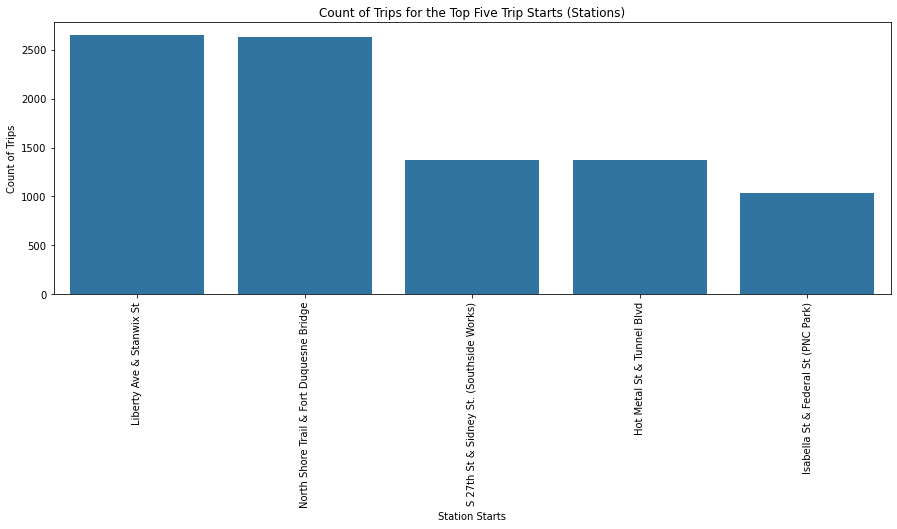

In [15]:
top_starts_df = df_StoS[df_StoS['From station name'].isin(top_starts.index.to_list())]

plt.figure(figsize = [15,5])
sns.countplot(data = top_starts_df, x = 'From station name', color = sns.color_palette()[0], order = top_starts_df['From station name'].value_counts().index)
plt.xticks(rotation = 90)
plt.ylabel('Count of Trips')
plt.xlabel('Station Starts')
plt.title('Count of Trips for the Top Five Trip Starts (Stations)')
;

In [16]:
# Most trips end here
top_ends = df_StoS['To station name'].value_counts().head(5)
top_ends

Liberty Ave & Stanwix St                    2906
North Shore Trail & Fort Duquesne Bridge    2700
S 27th St & Sidney St. (Southside Works)    1466
Hot Metal St & Tunnel Blvd                  1463
Isabella St & Federal St (PNC Park)         1099
Name: To station name, dtype: int64

''

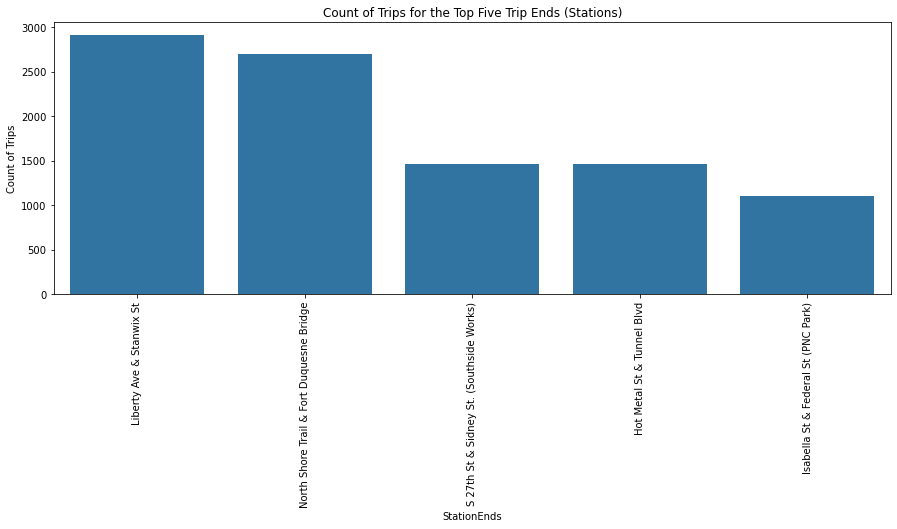

In [17]:
top_ends_df = df_StoS[df_StoS['To station name'].isin(top_ends.index.to_list())]

plt.figure(figsize = [15,5])
sns.countplot(data = top_ends_df, x = 'To station name', color = sns.color_palette()[0], order = top_ends_df['To station name'].value_counts().index)
plt.xticks(rotation = 90)
plt.ylabel('Count of Trips')
plt.xlabel('StationEnds')
plt.title('Count of Trips for the Top Five Trip Ends (Stations)')
;

### Station Utilization: What are the most frequent trip routes?

In [18]:
# These are the most popular trip routes
df_StoS['routes'] = 'From ' + df_StoS['From station name'] + ' To  ' + df_StoS['To station name']

df_StoS['routes'].value_counts().head(5)

From North Shore Trail & Fort Duquesne Bridge To  North Shore Trail & Fort Duquesne Bridge    1997
From Liberty Ave & Stanwix St To  Liberty Ave & Stanwix St                                    1708
From Hot Metal St & Tunnel Blvd To  Hot Metal St & Tunnel Blvd                                 959
From S 27th St & Sidney St. (Southside Works) To  S 27th St & Sidney St. (Southside Works)     900
From Isabella St & Federal St (PNC Park) To  Isabella St & Federal St (PNC Park)               625
Name: routes, dtype: int64

''

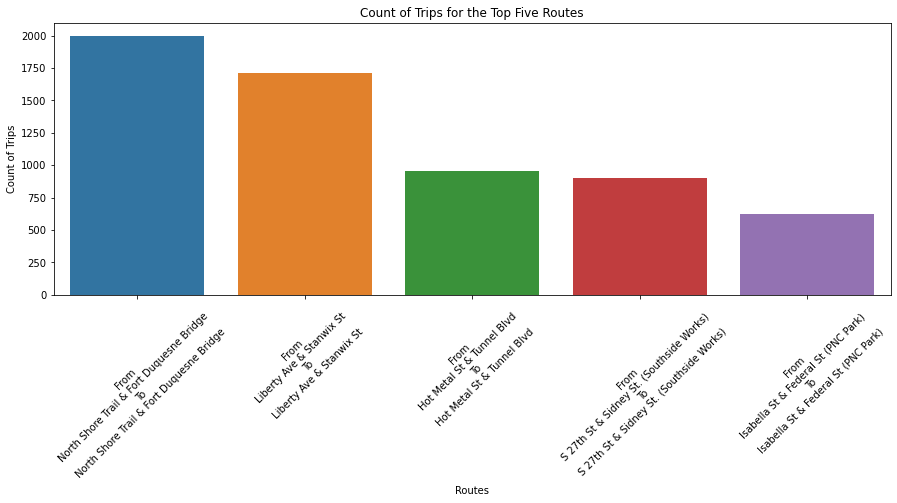

In [19]:
# Add new line characters to routes column for ease of labeling x-axis
df_StoS['routes'] = 'From\n' + df_StoS['From station name'] + '\nTo\n ' + df_StoS['To station name']

top_routes_df = df_StoS[df_StoS['routes'].isin(df_StoS['routes'].value_counts().head(5).index.to_list())]

plt.figure(figsize = [15,5])

sns.countplot(data = top_routes_df, x = 'routes', order = top_routes_df['routes'].value_counts().index)

plt.xticks(rotation = 45)
plt.ylabel('Count of Trips')
plt.xlabel('Routes')
plt.title('Count of Trips for the Top Five Routes')
;

### Bicycle Utilization
What is the total trip duration of each bike? Are some bikes used more often than others?

''

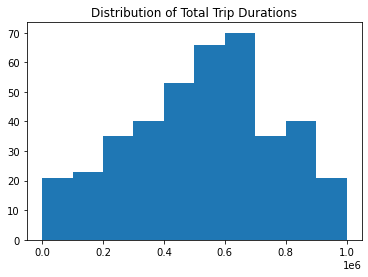

In [20]:
# Calculate the sum of TripSeconds by Bike
bike_duration_sums = df.groupby('Bikeid').sum()['TripSeconds']
plt.hist(bike_duration_sums, bins = np.arange(0,1100000,100000))
plt.title('Distribution of Total Trip Durations')
;

''

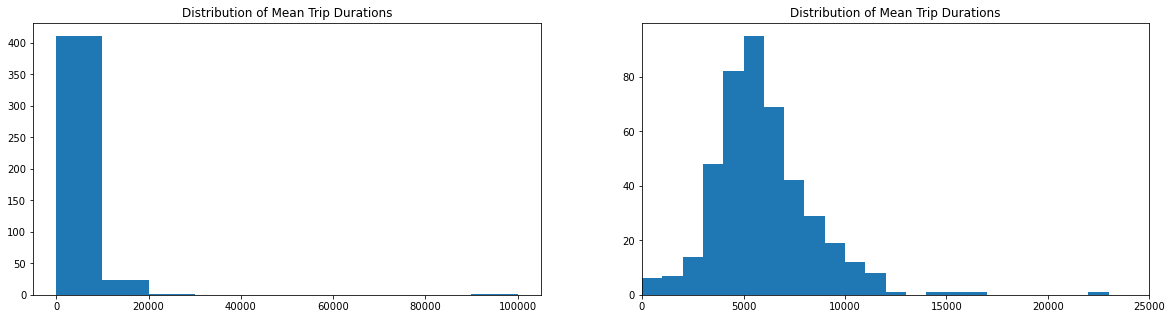

In [21]:
# Calculate the mean of TripSeconds by Bike
bike_duration_mean = df.groupby('Bikeid').mean()['TripSeconds']

plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
plt.hist(bike_duration_mean, bins = np.arange(0,110000,10000))
plt.title('Distribution of Mean Trip Durations')

plt.subplot(1,2,2)
plt.hist(bike_duration_mean, bins = np.arange(0,26000,1000))
plt.xlim(0,25000)
plt.title('Distribution of Mean Trip Durations')

;

### Trip Duration by User Type
Is there a significant difference in trip duration between subscribers and customers?

7586.652214068294 7986.004951880936


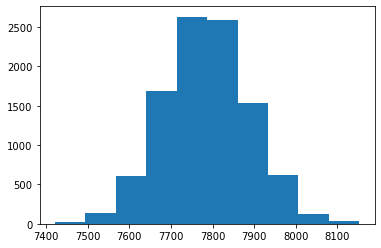

In [22]:
# Bootstrapped sample of Subscriber trip duration
boot_10k_sub = []
for _ in range(10000):
    sample = df.sample(len(df), replace = True)
    subscriber_mean_tripduration = sample.groupby('Usertype').mean()['TripSeconds'][0]
    boot_10k_sub.append(subscriber_mean_tripduration)

print(np.percentile(boot_10k_sub,2.5),np.percentile(boot_10k_sub,97.5))
plt.hist(boot_10k_sub);

1433.7367071313738 1603.100471239028


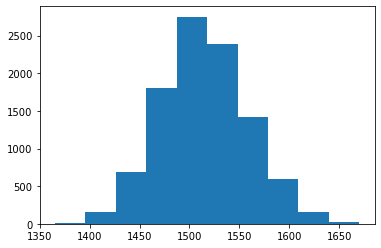

In [23]:
# Bootstrapped sample of Customer trip duration
boot_10k_cus = []
for _ in range(10000):
    sample = df.sample(len(df), replace = True)
    customer_mean_tripduration = sample.groupby('Usertype').mean()['TripSeconds'][1]
    boot_10k_cus.append(customer_mean_tripduration)

print(np.percentile(boot_10k_cus,2.5),np.percentile(boot_10k_cus,97.5))
plt.hist(boot_10k_cus);

''

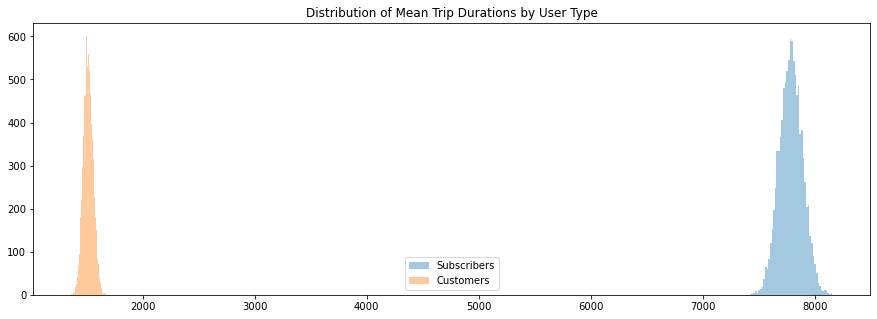

In [24]:
plt.figure(figsize = [15,5])
sns.distplot(boot_10k_sub, kde=False)
sns.distplot(boot_10k_cus, kde=False)
plt.legend(['Subscribers','Customers'])
plt.title('Distribution of Mean Trip Durations by User Type')
;

### Trip duration by time of week
Is there a significant difference in trip duration between trips taken during the week and those taken during the weekend?

In [25]:
# Bootstrapped sample of weekday trip duration
boot_10k_weekday = []
for _ in range(10000):
    sample = df.sample(len(df), replace = True)
    day_type_mean_tripduration = sample.groupby('day_type').mean()['TripSeconds'][0]
    boot_10k_weekday.append(day_type_mean_tripduration)

print(np.percentile(boot_10k,2.5),np.percentile(boot_10k,97.5))
plt.hist(boot_10k_weekday);

NameError: name 'boot_10k' is not defined

In [ ]:
# Bootstrapped sample of weekend trip duration
boot_10k_weekend = []
for _ in range(10000):
    sample = df.sample(len(df), replace = True)
    day_type_mean_tripduration = sample.groupby('day_type').mean()['TripSeconds'][1]
    boot_10k_weekend.append(day_type_mean_tripduration)

print(np.percentile(boot_10k,2.5),np.percentile(boot_10k,97.5))
plt.hist(boot_10k_weekend);

In [ ]:
plt.figure(figsize = [15,5])
bins = np.arange(5100,6600,50)
sns.distplot(boot_10k_weekday, kde=False, bins = bins)
sns.distplot(boot_10k_weekend, kde=False, bins = bins)
plt.legend(['Weekday','Weekend'])
plt.title('Distribution of Mean Trip Durations by Time of Week')
;

### Trip Duration Model
Given this dataset, can trip duration be adequately modeled using data on user type, trip type, and whether or not a trip takes place during the week or weekend?

In [ ]:
trip_model_data = df.drop(columns = ['Trip id', 'Starttime', 'Stoptime', 'Bikeid',
       'From station id', 'From station name', 'To station id',
       'To station name', 'day_of_week'])

#Create a copy of the dataframe
cat_df_copy = trip_model_data.copy()
#Pull a list of the column names of the categorical variables
cat_cols_lst = trip_model_data.drop(columns =['TripSeconds']).columns

def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

df_new = create_dummy_df(trip_model_data, cat_cols_lst, dummy_na=False)

df_new.head()

In [ ]:
#Split into explanatory and response variables
X = df_new[['Usertype_Subscriber', 'trip_type_Station to Station', 'day_type_Weekend']]
y = df_new['TripSeconds']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)


In [ ]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

## 4.  Summary of Insights <a class="anchor" id="chapter4"></a>
This section creates final visualizations of actionable insights for focusing maintenance efforts on Healthy Ride's most utilized assets.